# Create a dataset
In this notebook I introduce how to compute a dataset from numpy imported data. Especially tensors with labels.


In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Dataset creation: 2
Create a dataset starting from random velocity fields and computing their divercenge

In [ ]:
# Number of elements of the dataset and size of the picture
d_size = 250
(N_x, N_y) = (128,128)

# Let us create the needed dataset:(features, labels)

def create_dataset(d_size : int, N_x : int, N_y : int):
    """
        - d_size: Size of the dataset
        - N_x: Spatial dimension on the x-axis
        - N_y: Spatial dimension on the y-axis
        - filtering_radius: Spatial dimension on the y-axis
        Return dataset with the previous
        """
    features = np.zeros((d_size, N_x, N_y, 1))
    for i in range(d_size):
        # define the velocity field
        stddev = 0.3
        u_t = tf.random.normal(shape=(1,N_x,N_y,1), stddev=stddev)
        v_t = tf.random.normal(shape=(1,N_x,N_y,1), stddev=stddev)

        # Define derivatives templates
        D_x = 0.5 * tf.constant(
            [[0., -1., 0.],
            [0., 0., 0.],
            [0., 1., 0.]]
        )
        D_x = tf.reshape(D_x, [3,3,1,1])
        D_y = 0.5 * tf.constant(
            [[0., 0., 0.],
            [-1., 0., 1.],
            [0., 0., 0.]]
        )
        D_y = tf.reshape(D_y, [3,3,1,1])

        # Divergence of velocity field
        u_x = tf.nn.convolution(u_t, D_x, padding="SAME")
        u_y = tf.nn.convolution(v_t, D_y, padding="SAME")
        div_u = u_x + u_y

        # print(div_u.numpy().shape)
        features[i,:,:,:] = div_u.numpy()[0,:,:,:]
        print(i, end="\r")

    # In my case the labels and the features coincide
    # --------- BUILDING DATASET --------- #
    dataset = tf.data.Dataset.from_tensor_slices((features, features))
    # --------- BUILDING DATASET --------- #
    return dataset

# Dataset creation: 3
This time i compute the dataset as b = lap_p for a given p ensuring that the solution to A p = b

In [3]:
# Number of elements of the dataset and size of the picture
d_size = 250
(N_x, N_y) = (128,128)

# Laplacian filter
L = tf.constant(
    [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]], dtype=tf.float32)
L = tf.reshape(L, [3,3,1,1])

def create_dataset(d_size : int, N_x : int, N_y : int):
    """
        - d_size: Size of the dataset
        - N_x: Spatial dimension on the x-axis
        - N_y: Spatial dimension on the y-axis
        Return dataset with the previous
    """
    # Let us create the needed dataset:(features, labels)
    features = np.zeros((d_size, N_x, N_y, 1))
    for i in range(d_size):
        # define the velocity field
        stddev = 1/20
        p_true = tf.random.normal(shape=(1,N_x,N_y,1), stddev=stddev)

        # Divergence of velocity field
        div_u = tf.nn.convolution(p_true, L, padding="SAME")

        # print(div_u.numpy().shape)
        features[i,:,:,:] = div_u.numpy()[0,:,:,:]
        print(i, end="\r")

    # In my case the labels and the features coincide
    # --------- BUILDING DATASET --------- #
    dataset = tf.data.Dataset.from_tensor_slices((features, features))
    # --------- BUILDING DATASET --------- #
    return dataset

dataset = create_dataset(d_size, N_x, N_y)


# Dataset creation
in this case we build a robust dataset starting from different smooth pressure layers (so that we generate a feature that is a solution for the problem)
with different variabilities

In [16]:
# Number of elements of the DATASET and size of domain
d_size = 1000
(N_x, N_y) = (128,128)

import numpy as np
import random
import matplotlib.pyplot as plt
from myPackageUtils.spatial_filter import spatial_filter

def create_dataset_spatial_filtering(d_size : int, N_x : int, N_y : int, filtering_radius : int):
    """
        - d_size: Size of the dataset
        - N_x: Spatial dimension on the x-axis
        - N_y: Spatial dimension on the y-axis
        - filtering_radius: Spatial dimension on the y-axis
        Return dataset with the previous
    """
    x = np.arange(N_x)
    y = np.arange(N_y)

    # Laplacian filter
    L = tf.constant(
        [[0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]], dtype=tf.float64)
    L = tf.reshape(L, [3,3,1,1])

    # Let us create the needed dataset:(features, labels)
    features = np.zeros((d_size, N_x, N_y, 1))
    for i in range(d_size):
        # define the velocity field
        random_noise1 = np.random.normal(size=(N_x, N_y))
        p_true = spatial_filter(random_noise1, char_len=random.uniform(0,filtering_radius)).astype(np.double)
        p_true = tf.constant(p_true.reshape((1,N_x, N_y,1)), dtype=tf.float64)

        # Divergence of velocity field - Normalization
        div_u = tf.nn.convolution(p_true, L, padding="SAME")
        div_std = tf.math.reduce_std(div_u)
        div_u = 0.2*div_u/div_std

        # print(div_u.numpy().shape)
        features[i,:,:,:] = div_u.numpy()[0,:,:,:]
        print(i, end="\r")

    # In my case the labels and the features coincide
    # --------- BUILDING DATASET --------- #
    dataset = tf.data.Dataset.from_tensor_slices((features, features) )
    # --------- BUILDING DATASET --------- #
    return dataset

In [ ]:
# Print a sample of the dataset
ds1 = dataset.take(9)
print(ds1)

i=1
for (feature, label) in ds1:
    plt.subplot(3,3,i)
    plt.imshow(feature)
    plt.colorbar()
    i=i+1

ds1 = dataset.take(9)
plt.figure()
for feature, label in ds1:
    plt.hist(feature.numpy().flatten(), bins=100)
    print("Standard deviation:\t", np.std(feature), "\tMaximum value:\t", np.max(feature))

# Code to create and save dataset
This piece of code creates the dataset by calling its function and saves it. It does it in chunks

/tmp/ipykernel_61458/2194312347.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  p_true = spatial_filter(random_noise1, char_len=random.uniform(0,filtering_radius)).astype(np.double)


<_TakeDataset element_spec=(TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None))>
tf.Tensor(
[[[-0.73293843]
  [-0.24656925]
  [-0.21033443]
  ...
  [-0.51930927]
  [-0.44224113]
  [-0.75570235]]

 [[-0.45808348]
  [ 0.03576717]
  [ 0.03104733]
  ...
  [ 0.02582632]
  [ 0.03136059]
  [-0.43309679]]

 [[-0.55399599]
  [ 0.03634389]
  [ 0.03207353]
  ...
  [ 0.02765283]
  [ 0.0320987 ]
  [-0.54247179]]

 ...

 [[-0.34561128]
  [-0.00387277]
  [-0.00238548]
  ...
  [-0.03167016]
  [-0.0220439 ]
  [-0.24299513]]

 [[-0.36215971]
  [ 0.00837087]
  [ 0.00739099]
  ...
  [-0.01403914]
  [-0.00518736]
  [-0.28000914]]

 [[-0.7642646 ]
  [-0.33391039]
  [-0.31504747]
  ...
  [-0.52531003]
  [-0.4708531 ]
  [-0.7470384 ]]], shape=(128, 128, 1), dtype=float64)
tf.Tensor(
[[[2.38379521e+00]
  [1.15064715e+00]
  [1.11020970e+00]
  ...
  [1.34554573e+00]
  [1.29205976e+00]
  [2.38665391e+00]]

 [[1.13611011e+00]
  [1.90532807e-03

2025-06-23 16:15:43.373900: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


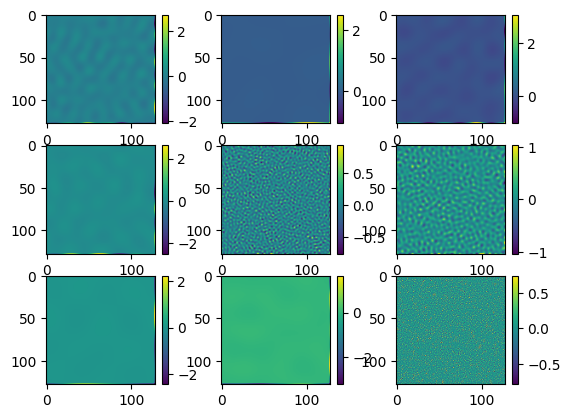

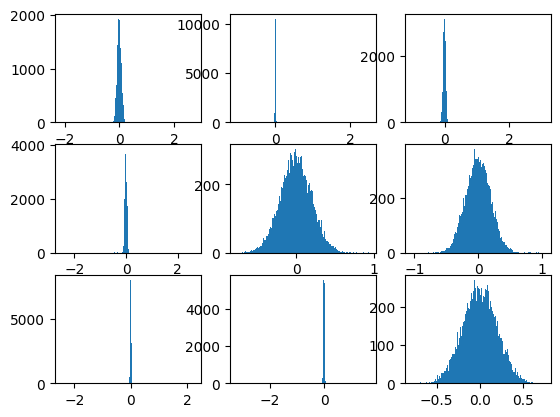

: 

In [ ]:
# Create and save dataset
import os
import shutil
from myPackageUtils.dataset_utils import save_dataset

dataset_folder = "saved_data/"
filename = "dataset"
# Delete the Dataset folder
overwrite = True
path = (os.path.join(os.getcwd(), dataset_folder))
if (overwrite == True) and (os.path.exists(path)):
    shutil.rmtree(path)

for i in range(10):
    dataset = create_dataset_spatial_filtering(d_size, N_x, N_y, filtering_radius=50)

    path = (os.path.join(os.getcwd(), (dataset_folder+filename+str(i))))
    save_dataset(dataset, path, True)


# Plot sampled loaded dataset elements
ds1 = dataset.take(9)
print(ds1)

i=1
for (feature, label) in ds1:
    plt.subplot(3,3,i)
    plt.imshow(feature)
    plt.colorbar()
    i=i+1

i=1
plt.figure()
for (feature, label) in ds1:
    plt.subplot(3,3,i)
    plt.hist(feature.numpy().flatten(), bins=200)
    print(feature)
    i=i+1


# Save/Load a Dataset on disk

In [7]:
# Save the dataset to a file for later use
import os
# Save the dataset to a file for later use
from myPackageUtils.dataset_utils import save_dataset

dataset_folder = "saved_data"
path = (os.path.join(os.getcwd(), dataset_folder))

overwrite = True
save_dataset(dataset, path, overwrite)

In [ ]:
# Improved version for loading the chinks of dataset from a folder and joining them
import os
import importlib
import myPackageUtils.dataset_utils
importlib.reload(myPackageUtils.dataset_utils)

from myPackageUtils.dataset_utils import load_dataset

dataset_folder = "saved_data"
path = (os.path.join(os.getcwd(), dataset_folder))
dataset = load_dataset(path)


In [ ]:
# # Load the dataset
# new_dataset = tf.data.Dataset.load(path)

# # Check dataset
# ds1 = new_dataset.take(1)
# plt.figure(figsize=(11,4))

# for (feature, label) in ds1:
#     plt.subplot(1,2,1)
#     plt.imshow(feature)
#     plt.colorbar()

#     plt.subplot(1,2,2)
#     plt.imshow(label - feature)
#     plt.colorbar()

